In [1]:
import os 
import time
import copy
import math 
import re
import json 

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import numpy as np
import pickle
import random 
import pandas as pd

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

using device cuda:0


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
def cuda(input):
    if torch.cuda.is_available(): return input.cuda()
    return input

In [4]:
path = !pwd
path = path[0]
print(path)

/home/r2/Documents/RNNexp


In [5]:
# data = pd.read_pickle(path+"/data/step3_DAT_MT_USDJPY_M1_2018_merged_pickled") 
# data.head()

### functions

In [6]:
class Struct():
    pass 

def load_trumpdata(datapath, pad_tok='£', start_tok='^', end_tok='€'):

    van_tws, tws, van_tw_str, tw_str = [],[],'',''
    filenames = ['condensed_2018.json', 'condensed_2016.json', 'condensed_2017.json', 'condensed_2018.json']
    for fname in filenames:
        f = open(datapath+fname,"r")
        data = f.readline()
        f.close()
        data_tr = json.loads(data)
        for line in range(0,len(data_tr)):
            tweet      = data_tr[line]["text"].rstrip('\\')
            van_tw_str = van_tw_str + tweet 
            van_tws.append(tweet)            
    symbols = list(set(van_tw_str))  
    assert(pad_tok   not in symbols)
    assert(start_tok not in symbols)
    assert(end_tok   not in symbols)

    for tweet in van_tws:
        pad_tweet = start_tok + tweet + end_tok
        tw_str    = tw_str + pad_tweet            
        tws.append(pad_tweet)        
    symbols = [pad_tok] + symbols + [start_tok, end_tok]   
    decoder = {idx: symbols[idx] for idx in range(0,len(symbols))}
    encoder = {symbols[idx]: idx for idx in range(0,len(symbols))}        
    return tws, tw_str, decoder, encoder

def pp_trumpdata(filename, prop, bsize=1):
    Data, train, valid, test = Struct(), Struct(), Struct(), Struct()        
    tweets, tweet_str, Data.decoder, Data.encoder = load_trumpdata(filename)    

    train.tweets = tweets[0:round(prop[0]*len(tweets))]
    train.tweet_str = tweet_str[0:round(prop[1]*len(tweet_str))]    
    valid.tweets = tweets[round(prop[0]*len(tweets)):round(prop[1]*len(tweets))]
    valid.tweet_str = tweet_str[round(prop[0]*len(tweet_str)):round(prop[1]*len(tweet_str))]    
    test.tweets  = tweets[round(prop[1]*len(tweets)):-1]
    test.tweet_str  = tweet_str[round(prop[1]*len(tweet_str)):-1]    

    train.batch_str = []
    stepsize = round(len(train.tweet_str)/bsize-1)
    for i in range(0,bsize):
        train.batch_str.append(train.tweet_str[i*stepsize:(i+1)*stepsize])
    valid.batch_str = [valid.tweet_str]
    
    Data.train, Data.valid, Data.test, Data.bsize = train, valid, test, bsize
    return Data

def save_checkpoint(state, filename='models/checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='models/checkpoint.pth.tar'):
    checkpoint = torch.load(filename)    
    for item in iter(checkpoint):
        print(item)
    model = RNN(checkpoint['in_sz'],checkpoint['hd_sz'],checkpoint['out_sz'])
    model.load_state_dict(checkpoint['state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch, loss    

def get_valid_loss(model,Data,Params,seq_len,ntweet):
    criterion = nn.NLLLoss()
    start = time.time()
    loss_valid = 0
    hidden = cuda(torch.zeros(1,model.hd_sz))
    with torch.no_grad():    
        model.eval()
        for t in range(ntweet):
            tweet = Data.valid.tweets[t]
            xv, yv = generate_valid(Data,tweet,seq_len)     
            loss = 0
            for char in range(xv.size()[1]):
                x = xv[:,char,:].reshape(xv.shape[0],xv.shape[2])
                output, hidden = model.forward(x,hidden)
                y = yv[:,char,:]
                loss += criterion(output,y.reshape(xv.shape[0]))
            loss_valid += loss/(xv.size()[2])
#     print(f"calculating validation loss took {time.time()-start:.2f} seconds")
    return loss_valid/ntweet

def generate_valid(Data, tweet, seq_len):
    if seq_len > len(tweet)-1: seq_len = len(tweet)-1    
    X = torch.zeros(1,seq_len,len(Data.encoder))
    Y = torch.zeros(1,seq_len,1)  
    x = encodestr(tweet[0:seq_len],Data.encoder)
    y = torch.Tensor([Data.encoder[char] for char in tweet[1:seq_len+1]])
    X[0,:,:] = x.reshape(seq_len,len(Data.encoder))
    Y[0,:,:] = y.reshape(seq_len,1)
    return cuda(X),cuda(Y.long())

def init_params(in_sz, bs, hd_sz=150):
    Params = Struct()
    Params.ni      = 3000
    Params.ne      = 1
    Params.hd_sz   = hd_sz
    Params.in_sz   = in_sz
    Params.sql     = 10
    Params.iv_pr   = 200
    Params.iv_pl   = 100
    Params.n_e     = 1
    Params.n_i     = 1000
    Params.use_opt = True 
    Params.lr      = 0.0005
    Params.bs      = bs
    return Params

### encoder/decoders 

In [7]:
def encodestr(string, encoder):
    x = torch.zeros((len(string),len(encoder)))
    x[[idx for idx in range(0,len(string))],[encoder[char] for char in string]] = 1
    return x

def onehencode(symbol, encoder):
    x = torch.zeros(len(encoder),1)
    x[encoder[symbol]] = 1.0
    return x.t()

def encode(string, encoder):
    return torch.Tensor([encoder[char] for char in y_str])

def onehdecode(X,decoder):
    string = ''
    for char in range(X.shape[0]):
        val, idx = torch.max(X[char],0)
        string += decoder[idx.item()]
    print(string)
    
def ydecode(Y,decoder):
    string = ''
    for char in range(Y.shape[0]): string += decoder[Y[char].item()]
    print(string)

def change_char(s, p, r):
    return s[:p]+r+s[p+1:] 

def generate_seq(model,Data,sql,symbol='^'):
    with torch.no_grad():
        hidden = model.initHidden(1)
        result = symbol
        for i in range(sql):
            x = cuda(onehencode(symbol,Data.encoder))
            output, hidden = model.forward(x,hidden)        
            hidden = hidden.detach()
            
            prob     = np.exp(output[0].cpu().numpy())
            cum_prob = np.cumsum(prob)
            idx      = np.where(cum_prob - random.random() > 0)[0][0]
            symbol   = Data.decoder[idx]
            result  += symbol
    print(result)

## my RNN module

In [8]:
class RNNoriginal(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNoriginal,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        self.h1  = nn.Linear(input_size + hidden_size, hidden_size)               
        self.o1   = nn.Linear(input_size + hidden_size, input_size)

        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNoriginal,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, hidden_size)               
        self.o1      = nn.Linear(combined, combined)
        self.bn1     = nn.BatchNorm1d(combined, combined)
        self.relu    = nn.ReLU(combined,combined)

        self.o2      = nn.Linear(combined, input_size)
        self.bn2     = nn.BatchNorm1d(input_size,input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))


    
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

def weights_init_xavier(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    

### DataLoaders, Itterators, DataSets

In [15]:
def make_parentbatch(tweets, bs, sql, symbol='£'):
    f"""each parent-batch will have different numbers of sub-batches depending on how long the tweets are"""
    assert(len(tweets)/bs*10%2==0)
    bch_strs = batch_strings(tweets,bs,sql)
    parent_batches = []
    for pb in range(len(bch_strs)):
        bch       = bch_strs[pb]
        n_tweet   = bs
        n_segment = math.ceil(len(bch[0])/sql)
        sbx = torch.zeros(n_tweet,n_segment,sql,len(Data.decoder))
        sby = torch.zeros(n_tweet,n_segment,sql).long()

        for tweet in range(n_tweet):
            if re.search(symbol,bch[tweet]): position = re.search(symbol,bch[tweet]).span()[0]
            else:                            position = len(bch[tweet])
            x_str = change_char(bch[tweet],position-1,symbol)
            y_str = bch[tweet][1:len(bch[tweet])]+symbol                
            for segment in range(n_segment):
                x = x_str[sql*segment:sql*(segment+1)]
                y = y_str[sql*segment:sql*(segment+1)]  
                sbx[tweet,segment] = encodestr(x,Data.encoder)
                sby[tweet,segment] = torch.Tensor([Data.encoder[char] for char in y])                
                
        sb_ds = SBDataLoader(sbx, sby)
        parent_batches.append(sb_ds)
    return parent_batches


def batch_strings(tweets,bs,sql=1):
    f"""creates a list of batchsize-list of strings of same length and sort each batch with longest string first."""
    offset = -1*(int(len(tweets)/bs * 10) % 2 != 0)
    bch_strs = [] 
    for i in range(round(len(tweets)/bs)+offset):
        strings = tweets[i*bs:(i+1)*bs]
        strings.sort(key=len,reverse=True)
        pad_strings = pad(strings,sql)
        bch_strs.append(pad_strings)
    return bch_strs

def pad(str_list,sql=1,token='£'):
    f"""pad all strings in a list to max_len"""
    max_len = math.ceil(len(max(str_list, key=len))/sql)*sql
    for idx, row in enumerate(str_list):        
        str_list[idx] = row + token*(max_len-len(row))
    if len(str_list) == 1: return str_list[0]
    return str_list

class ParentDataLoader():
    def __init__(self, ds): 
        self.ds = ds
    def __iter__(self):    
        for i in range(len(self.ds)):
            iterator = iter(self.ds[i])
            yield next(iterator), True
            try:
                while True:                
                    yield next(iterator), False 
            except StopIteration:
                pass

class SBDataLoader():
    def __init__(self, sbx, sby): 
        self.sbx, self.sby = sbx, sby
    def __iter__(self):
        for j in range(self.sbx.shape[1]): yield cuda(self.sbx[:,j]), cuda(self.sby[:,j])

def train_model(model,Params,dataloader,n_itter,plot_valid=None):
    optimizer = optim.RMSprop(model.parameters(), lr=Params.lr)
    criterion = nn.NLLLoss()
    hidden = rnn.initHidden(Params.bs)    
    
    start = time.time()
    if plot_valid is None: plot_valid = []
    plot_train = []
        
    for i in range(n_itter):
        optimizer.zero_grad()

        (X,Y), usezerostate    = next(dataloader)
        X,Y                    = cuda(X),cuda(Y)
        if usezerostate: hidden = rnn.initHidden(Params.bs)

        loss = 0
        for char in range(X.shape[1]):
            x,y = X[:,char],Y[:,char]

            f"""remove padded characters"""
            idx = (y != 0).nonzero()
            if idx.shape[0] == 0: break
            if idx.shape[0] == 1: idx = idx.squeeze(0)
            else:                 idx = idx.squeeze()

            hidden = hidden[idx]
            x = x[idx]
            y = y[idx]


            output,hidden = model.forward(x,hidden)
            loss += criterion(output,y)        

        if loss != 0:
            loss.backward()
            optimizer.step()
            hidden = hidden.detach()

        if i%100==0: 
            plot_valid.append(get_valid_loss(rnn,Data,Params,30,50))
        if i%500==0: print(f"""checkpoint: {i} itterations done in {time.time() - start} seconds""")
    del optimizer
    del criterion
    print(f"""this training took {time.time()-start} seconds""")
    return model,dataloader,plot_valid


### start coding 

In [10]:
bs        = 15
Data      = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
Params    = init_params(len(Data.encoder),bs)

In [11]:
tweets = Data.train.tweets
loader = ParentDataLoader(make_parentbatch(tweets,bs,sql=Params.sql))

In [16]:
# rnn = cuda(RNN(Params.in_sz, Params.hd_sz, 1))
# dataloader = iter(copy.deepcopy(loader))
n_itter = 3000
rnn,dataloader,plot_valid = train_model(rnn,Params,dataloader,n_itter,plot_valid)

checkpoint: 0 itterations done in 0.6407127380371094 seconds
checkpoint: 500 itterations done in 13.249198913574219 seconds
checkpoint: 1000 itterations done in 25.665111780166626 seconds
checkpoint: 1500 itterations done in 37.86642074584961 seconds
checkpoint: 2000 itterations done in 50.09713387489319 seconds
checkpoint: 2500 itterations done in 62.398521184921265 seconds
this training took 73.95132422447205 seconds


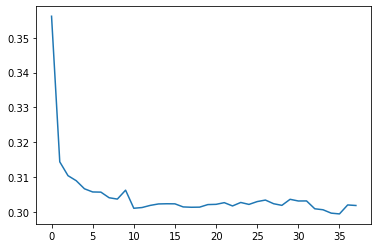

In [18]:
plt.figure()
plt.plot(plot_valid[1:-1])
plt.show()

In [40]:
temp_loader = iter(copy.deepcopy(dataloader))
Plots = Struct()
Plots.valid1 = [] 

start = time.time()
for i in range(500):
    optimizer.zero_grad()

    (X,Y), usezerostate    = next(temp_loader)
    X,Y                    = cuda(X),cuda(Y)
    if usezerostate: hidden = rnn.initHidden(bs)

    loss = 0

    for char in range(X.shape[1]):
        x,y = X[:,char],Y[:,char]
    
        f"""remove padded characters"""
        idx = (y != 0).nonzero()
        if idx.shape[0] == 0: break
        if idx.shape[0] == 1: idx = idx.squeeze(0)
        else:                 idx = idx.squeeze()
                                                
        hidden = hidden[idx]
        x = x[idx]
        y = y[idx]

        
        output,hidden = rnn.forward(x,hidden)
        loss += criterion(output,y)        

    if loss != 0:
        loss.backward()
        optimizer.step()
        hidden = hidden.detach()
        
    if i%100==0: 
        Plots.valid1.append(get_valid_loss(rnn,Data,Params,30,50))

#         Plots.train_loss.append(loss/X.size()[2])
    if i%500==0: print(f"""checkpoint: {i} itterations done in {time.time() - start} seconds""")
        
print(f"""this training took {time.time()-start} seconds""")

checkpoint: 0 itterations done in 0.7538394927978516 seconds
this training took 12.662439584732056 seconds


In [ ]:
def train_model(model,Params,dataloader,n_itter,plot_valid=None)
    optimizer = optim.RMSprop(model.parameters(), lr=Params.lr)
    criterion = nn.NLLLoss()
    
    start = time.time()
    if plot_valid is None: plot_valid = []
    plot_train = []
        
    for i in range(n_itter):
        optimizer.zero_grad()

        (X,Y), usezerostate    = next(data_loader)
        X,Y                    = cuda(X),cuda(Y)
        if usezerostate: hidden = rnn.initHidden(Params.bs)

        loss = 0
        for char in range(X.shape[1]):
            x,y = X[:,char],Y[:,char]

            f"""remove padded characters"""
            idx = (y != 0).nonzero()
            if idx.shape[0] == 0: break
            if idx.shape[0] == 1: idx = idx.squeeze(0)
            else:                 idx = idx.squeeze()

            hidden = hidden[idx]
            x = x[idx]
            y = y[idx]


            output,hidden = model.forward(x,hidden)
            loss += criterion(output,y)        

        if loss != 0:
            loss.backward()
            optimizer.step()
            hidden = hidden.detach()

        if i%100==0: 
            plot_valid.append(get_valid_loss(rnn,Data,Params,30,50))
        if i%500==0: print(f"""checkpoint: {i} itterations done in {time.time() - start} seconds""")
    del optimizer
    del criterion
    print(f"""this training took {time.time()-start} seconds""")
    return model,dataloader,plot_valid


In [21]:
rnn2 = cuda(RNN(Params.in_sz, Params.hd_sz, 1))
# rnn2.apply(weights_init_xavier)
optimizer2 = optim.RMSprop(rnn2.parameters(), lr=Params.lr)
criterion = nn.NLLLoss()

temp_loader = iter(copy.deepcopy(dataloader))
Plots.valid2 = [] 

start = time.time()
for i in range(1500):
    optimizer2.zero_grad()

    (X,Y), usezerostate    = next(temp_loader)
    X,Y                    = cuda(X),cuda(Y)
    if usezerostate: hidden = rnn2.initHidden(bs)

    loss = 0

    for char in range(X.shape[1]):
        x,y = X[:,char],Y[:,char]
    
        f"""remove padded characters"""
        idx = (y != 0).nonzero()
        if idx.shape[0] == 0: break
        if idx.shape[0] == 1: idx = idx.squeeze(0)
        else:                 idx = idx.squeeze()
                                                
        hidden = hidden[idx]
        x = x[idx]
        y = y[idx]

        
        output,hidden = rnn2.forward(x,hidden)
        loss += criterion(output,y)        

    if loss != 0:
        loss.backward()
        optimizer.step()
        hidden = hidden.detach()
        
    if i%100==0: 
        Plots.valid2.append(get_valid_loss(rnn2,Data,Params,30,50))

        Plots.train.append(loss/X.size()[2])
    if i%500==0: print(f"""checkpoint: {i} itterations done in {time.time() - start} seconds""")
        
print(f"""this training took {time.time()-start} seconds""")

checkpoint: 0 itterations done in 0.6499161720275879 seconds
checkpoint: 500 itterations done in 12.916450500488281 seconds
checkpoint: 1000 itterations done in 24.76442527770996 seconds
this training took 36.54662299156189 seconds


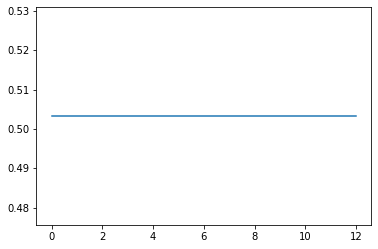

In [22]:
plt.figure()
# plt.plot(Plots.valid1[1:-1])
plt.plot(Plots.valid2[1:-1])
plt.show()

In [1]:
generate_seq(rnn,Data,100)

NameError: name 'generate_seq' is not defined

In [2]:
save_checkpoint({
            'epoch': epoch,
            'arch': "1_RNN",
            'state_dict': rnn.state_dict(),
            'hd_sz': rnn.hd_sz,
            'in_sz': rnn.in_sz,
            'out_sz': rnn.out_sz,
            'loss': loss,
            'best_prec1': None,
            'optimizer' : None,
        })

NameError: name 'save_checkpoint' is not defined

In [ ]:
rnn2, epoch, loss = load_checkpoint(filename='models/checkpoint.pth.tar')
rnn2.cuda()

In [ ]:
print(generate_seq(rnn2, torch.zeros(1,hsize).cuda(),'T',100,m,42))
print(generate_seq(rnn, torch.zeros(1,hsize).cuda(),'T',100,m,42))

### functions I should not need anymore

In [ ]:

def train_batch(model,X,Y,Data,hidden,lr,optimizer,use_opt,update_hidden):
    model.train()
    if use_opt: optimizer.zero_grad() 
    else: model.zero_grad()
    loss = 0
    for char in range(X.size()[1]):
        x = X[:,char,:].reshape(X.shape[0],X.shape[2])
        if update_hidden: hidden = parse_hidden(x,hidden,Data,symbol='*')        
        output, hidden = model.forward(x,hidden)
        y = Y[:,char,:]
        loss += criterion(output,y.reshape(X.shape[0]))
    loss.backward()
    if use_opt: optimizer.step()
    else:
        for p in model.parameters(): p.data.add_(-lr, p.grad.data)
    # hidden.detach() because we are done with training...
    return loss/(X.size()[2]), hidden.detach()


def generate_batch(e, Data, seq_len, get_valid=False):
    if get_valid: 
        batch_str, bsize = Data.valid.batch_str, 1        
    else: batch_str, bsize = Data.train.batch_str, Data.bsize
    X = torch.zeros(bsize,seq_len,len(Data.encoder))
    Y = torch.zeros(bsize,seq_len,1)
    for i in range(0,bsize):        
        x = encodestr(batch_str[i][e:e+seq_len],Data.encoder)
        y = torch.Tensor([Data.encoder[char] for char in batch_str[i][e+1:e+seq_len+1]])
        X[i,:,:] = x.reshape(seq_len,len(Data.encoder))
        Y[i,:,:] = y.reshape(seq_len,1)
    return cuda(X),cuda(Y.long())

def do_training(model,Data,Params,optimizer,update_hidden,Plots=0):
    if Plots==0:
        Plots = Struct()
        Plots.loss_train, Plots.loss_valid = [], []
    start      = time.time()
    loss_train = 0
    hidden     = cuda(torch.zeros(Params.bsize,model.hd_sz))
    for epoch in range(Params.ne):
        char_idx = 0
        i = 0 
        while i < Params.ni and char_idx < len(Data.train.batch_str[0])-Params.sql-1:
            X,Y          = generate_batch(char_idx, Data, Params.sql,False)
            loss, hidden = train_batch(model,X,Y,Data,hidden,Params.lr,optimizer,True,update_hidden)
            loss_train  += loss         
            if i%Params.iv_pl  == 0:  
                Plots.loss_valid.append(get_valid_loss(model,Data,Params,30,50))
                print(Plots.loss_valid[-1])
                Plots.loss_train.append(loss_train/Params.iv_pl)
                loss_train = 0 
            char_idx += Params.sql + 1
            i        += 1
        print(f"""\n epoch {epoch+1} took {time.time() - start:.2f} seconds""")  
    return Plots

def parse_hidden(x,hidden,Data,symbol='*'):
    # use .data to not break the connection to the graph     
    for i in range(0,x.shape[0]):
        if onehdecode(x[i,:],Data.decoder) == symbol:
            hidden.data[i,:] = torch.zeros(1,hidden.shape[1])
    return hidden

class RNNoriginal(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        self.h1  = nn.Linear(input_size + hidden_size, input_size + hidden_size)               
        self.o1   = nn.Linear(input_size + hidden_size, input_size + hidden_size)

        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))